# 5.2 PyTorch的nn模块

In [144]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from matplotlib import pyplot as plt

In [95]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
# 这里需要unsqueeze操作，将张量添加一维，变成矩阵。
# 该矩阵每一行代表每个样本，每列代表所有样本的某个特征。
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)
t_c.shape

torch.Size([11, 1])

In [96]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 7,  2,  8,  9,  6, 10,  3,  0,  1]), tensor([5, 4]))

In [97]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [98]:
linear_model = nn.Linear(1, 1) # 参数: input size, output size, bias(默认True)
linear_model(t_un_val)

tensor([[3.1929],
        [3.5636]], grad_fn=<AddmmBackward0>)

In [ ]:
linear_model.forward(t_un_val) # 虽然输出结果是一样的但不应该这样做!!

In [106]:
linear_model.weight

Parameter containing:
tensor([[0.1614]], requires_grad=True)

In [107]:
linear_model.bias

Parameter containing:
tensor([0.1657], requires_grad=True)

In [108]:
x = torch.ones(1)
linear_model(x)

tensor([0.3271], grad_fn=<ViewBackward0>)

上面的代码只对一个样本有效，需要创建大小为 B x Nin 的输入张量，其中 B 是批次的大小，而 Nin 是输入特征的数量，然后在模型中同时运行。
`模型希望输入的第0维为这个批次中的样本数目。这里假设对10个样本运行`

In [109]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.3271],
        [0.3271],
        [0.3271],
        [0.3271],
        [0.3271],
        [0.3271],
        [0.3271],
        [0.3271],
        [0.3271],
        [0.3271]], grad_fn=<AddmmBackward0>)

In [110]:
linear_model=nn.Linear(1,1)
optimizer=optim.SGD(linear_model.parameters(),lr=1e-2)

In [104]:
linear_model.parameters()

<generator object Module.parameters at 0x150f52c00>

In [105]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.1614]], requires_grad=True),
 Parameter containing:
 tensor([0.1657], requires_grad=True)]

In [111]:
# 使用nn.Linear模型来进行训练循环
def training_loop(n_epochs,optimizer,model,loss_fn,t_u_train,t_u_val,t_c_train,t_c_val,print_params=False,verbose=1000):
    for epoch in range(1,n_epochs+1):
        t_p_train=model(t_un_train) # 使用模型，在训练集上运行，得到训练集上的预测值
        loss_train=loss_fn(t_p_train,t_c_train) # 训练集上的误差
        t_p_val=model(t_un_val) # 使用模型，在验证集上运行，得到验证集上的预测值
        loss_val=loss_fn(t_p_val,t_c_val) # 验证集上的误差
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        if(epoch<=3 or epoch%verbose==0):
            print('Epoch %d, Training loss %.4f, Validation loss %.4f' %(epoch,float(loss_train),float(loss_val)))

在使用nn中的模型时，不能像之前那样显式的将params传入model中，因为nn中的模型本身内部就有parameters。

In [112]:
# 调用nn.Linear模型来进行训练，损失函数使用nn中的MSELoss
training_loop(n_epochs=3000,optimizer=optimizer,model=linear_model,loss_fn=nn.MSELoss(),t_u_train=t_un_train,t_u_val=t_un_val,t_c_train=t_c_train,t_c_val=t_c_val)
linear_model.weight,linear_model.bias

Epoch 1, Training loss 298.8854, Validation loss 155.2460
Epoch 2, Training loss 76.5778, Validation loss 8.7852
Epoch 3, Training loss 43.2075, Validation loss 1.5856
Epoch 1000, Training loss 3.5645, Validation loss 3.9228
Epoch 2000, Training loss 2.9793, Validation loss 3.3781
Epoch 3000, Training loss 2.9693, Validation loss 3.3140


(Parameter containing:
 tensor([[5.3834]], requires_grad=True),
 Parameter containing:
 tensor([-17.0641], requires_grad=True))

使用神经网络定义模型，通过nn.Sequential容器串联模块，该模型将1个输入特征散开为13个隐藏特征，然后将通过tanh激活函数，最后将得到的13个数字线性组合为1个输出特征。

In [113]:
seq_model=nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [114]:
seq_model.parameters()

<generator object Module.parameters at 0x150f51e00>

In [115]:
list(seq_model.parameters())

[Parameter containing:
 tensor([[ 0.2763],
         [ 0.5648],
         [ 0.0122],
         [ 0.3773],
         [ 0.5817],
         [ 0.2924],
         [ 0.4138],
         [-0.3752],
         [ 0.2027],
         [-0.5391],
         [ 0.4525],
         [-0.8015],
         [ 0.6377]], requires_grad=True),
 Parameter containing:
 tensor([-8.3552e-01, -5.0123e-02,  9.3605e-01,  5.2474e-01,  6.0475e-01,
         -7.1820e-01, -3.6183e-02, -3.9863e-01,  8.2841e-01, -1.3900e-04,
         -3.1943e-01, -2.4918e-01, -3.6005e-01], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0838,  0.0462, -0.0477,  0.2026, -0.1505, -0.0462,  0.0485, -0.0545,
           0.2578, -0.0470, -0.1084,  0.1363,  0.0259]], requires_grad=True),
 Parameter containing:
 tensor([-0.0099], requires_grad=True)]

In [117]:
for param in seq_model.parameters():
    print(param.shape)

torch.Size([13, 1])
torch.Size([13])
torch.Size([1, 13])
torch.Size([1])


有关nn.Modules参数的一些注意事项：当你检查由几个子模块组成的模型的参数时，可以方便地通过其名称识别参数。这个方法叫做named_parameters：

In [122]:
for(name,param) in seq_model.named_parameters():
    print(name,param.shape)

hidden_linear.weight torch.Size([13, 1])
hidden_linear.bias torch.Size([13])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


使用OrderedDict，给sequential的每个模块命名

In [139]:
seq_model=nn.Sequential(OrderedDict([
    ('hidden_linear',nn.Linear(1,8)),
    ('hidden_activation',nn.Tanh()),
    ('output_linear',nn.Linear(8,1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [140]:
for(name,param) in seq_model.named_parameters():
    print(name,param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [141]:
list(seq_model.parameters())

[Parameter containing:
 tensor([[ 0.6059],
         [ 0.7741],
         [ 0.3783],
         [ 0.9266],
         [-0.5072],
         [ 0.6221],
         [-0.9123],
         [-0.9463]], requires_grad=True),
 Parameter containing:
 tensor([-0.1607,  0.2939, -0.2049,  0.4546, -0.2915, -0.2622,  0.6386,  0.5461],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.2607,  0.3371,  0.1632, -0.0905,  0.1424, -0.1937, -0.0913,  0.2417]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2149], requires_grad=True)]

In [142]:
list(seq_model.hidden_linear.parameters())

[Parameter containing:
 tensor([[ 0.6059],
         [ 0.7741],
         [ 0.3783],
         [ 0.9266],
         [-0.5072],
         [ 0.6221],
         [-0.9123],
         [-0.9463]], requires_grad=True),
 Parameter containing:
 tensor([-0.1607,  0.2939, -0.2049,  0.4546, -0.2915, -0.2622,  0.6386,  0.5461],
        requires_grad=True)]

在训练循环中，打印出隐藏层线性部分的权重的梯度

In [143]:
optimizer=optim.SGD(seq_model.parameters(),lr=1e-3)
training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)
print('output',seq_model(t_un_val))
print('answer',t_c_val)
print('hidden',seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 209.1934, Validation loss 93.2512
Epoch 2, Training loss 205.0484, Validation loss 89.6146
Epoch 3, Training loss 201.0435, Validation loss 86.1117
Epoch 1000, Training loss 5.3030, Validation loss 3.8151
Epoch 2000, Training loss 4.7333, Validation loss 0.6234
Epoch 3000, Training loss 3.1919, Validation loss 0.5104
Epoch 4000, Training loss 2.5917, Validation loss 0.4785
Epoch 5000, Training loss 2.2415, Validation loss 0.5371
output tensor([[ 8.1143],
        [12.9778]], grad_fn=<AddmmBackward0>)
answer tensor([[ 8.],
        [11.]])
hidden tensor([[-1.5977e+01],
        [-3.1915e-01],
        [-1.6034e+01],
        [ 3.0708e-03],
        [ 4.5067e-01],
        [-1.2712e+01],
        [ 1.5335e+01],
        [ 9.1021e-01]])


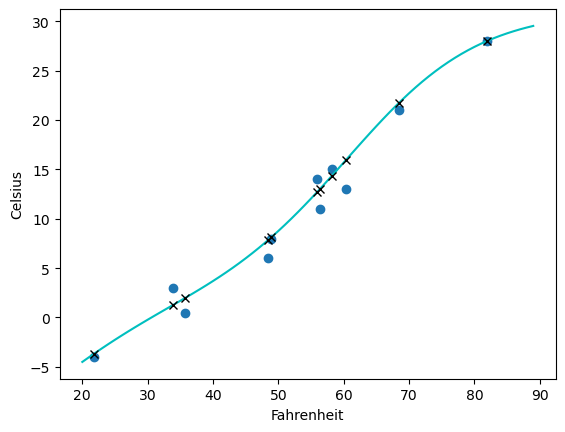

In [154]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
plt.show()

神经网络模型图示：输入数据（圆形），期望输出（叉号）和显示样本之间行为的连续曲线